# Kernel SHAP

In [1]:
import matplotlib.pyplot as plt

import sys
import h5py
import tensorflow as tf
import numpy as np
import pandas as pd
from skimage.segmentation import mark_boundaries

from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed

from matplotlib.colors import LinearSegmentedColormap
import shap # requires numpy 1.20.0

In [2]:
print('...')
print('--> VERSOES')
print("Versao python:", sys.version)
print("Versao de tensorflow:", tf.__version__)
print("Versao de Numpy:", np.__version__)

...
--> VERSOES
Versao python: 3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
Versao de tensorflow: 2.3.0
Versao de Numpy: 1.20.0


In [3]:
def ShapInterpreter(model, x_img, nsamples, seg_method='grid', grid_size=[3,10]):
    '''
    Aplica o método Kernel SHAP (Local Interpreter) em uma imagem aplicada no modelo classificador.
    
    Args.
        model: modelo treinado
        x_img: (1, im_height, im_width, 1) imagem a ser analisada
        seg_method: str com o método de segmentação utilizado
        nsamples: número de perturbações geradas aleatoriamente
        grid_size: [h_ration, w_ration] int com quantidade de quadrados (h: height | w: width)
    
    Returns.
        Plots do resultado do shap
        
    '''
    # Passo 1: Criar perturbações
    # -------------------------------------------------------------------------------------
    def to_rgb(img):
        '''
        Recebe imagem em grayscale (1 x height x width x 1) e copia para os outros canais, 
        retornando (1 x height x width x 3)

        '''
        x_rgb = np.zeros((img.shape[0],img.shape[1], img.shape[2], 3))

        for i in range(3):
            x_rgb[..., i] = img[..., 0]

        return x_rgb
    # -------------------------------------------------------------------------------------

    Xi = to_rgb(x_img) # converte para 3 canais
    Xi = Xi[0,...]

    # -------------------------------------------------------------------------------------
    # Segmentação

    # -------------------------------------------------------------------------------------
    def gridSegmentation(im, h_ratio, w_ratio):
        '''
        Define um Grid como Laberl array onde as regiões são marcadas por diferentes valores inteiros.

        Args.
            im: (im_height x im_width [, 3]) Grayscale or RGB image
            h_ration: [int] ration of squares in im_height
            w_ration: [int] ration of squares in im_width

        Returns.
            grid: (im_height x im_width [, 3]) Label array where regions are marked bu different integer values
        '''

        imgheight=im.shape[0]
        imgwidth=im.shape[1]

        i = 0
        M = imgheight//h_ratio
        N = imgwidth//w_ratio

        grid = np.ones((imgheight, imgwidth))

        for y in range(0,imgheight,M):
            for x in range(0, imgwidth, N):
                i = i+1
                grid[y:y+M, x:x+N] = i

        return grid
    # -------------------------------------------------------------------------------------
    
    #### ------------------------------ ####
    # Select segmentation method
    if seg_method == 'grid':
        superpixels = gridSegmentation(Xi, grid_size[0], grid_size[1]) # Segmentar em Grid
        
    elif seg_method == 'quickshift':
        superpixels = quickshift(Xi, kernel_size=10,max_dist=200, ratio=0.5)
        
    elif seg_method == 'slic':
        superpixels = slic(Xi, n_segments=20, compactness=10, sigma=1, start_label=1)
        
    elif seg_method == 'felzenszwalb':
        superpixels = felzenszwalb(Xi, scale=100, sigma=0.5, min_size=20)
        
    elif seg_method == 'watershed':
        gradient = sobel(rgb2gray(Xi))
        superpixels = watershed(gradient, markers=20, compactness=0.001)
        
    else:
        print('ERROR: Invalid segmentation method')
    
    #### ------------------------------ ####
    pd.DataFrame(superpixels).to_csv("ecgD2_SHAPsuperpixels.csv")
    #### ------------------------------ ####

    fig = plt.figure(figsize=(15,10))
    plt.imshow(mark_boundaries(Xi.astype(np.uint8), superpixels, mode='subpixels'))
    plt.title('Grid segmentation')
    plt.axis('off')
    fig.savefig('ecgD2_GridSegmentation.jpg')

    # - Número de superpixels gerado por cada método
    print(f'## Number of Superpixels: {len(np.unique(superpixels))}')

    # -------------------------------------------------------------------------------------
    # Criar perturbações aleatórias

    #### ------------------------------ ####
    print('## Segmentation method: ', seg_method)
    #### Numero de perturbações criadas ####
    print('## Number of Perturbations: ', nsamples)
    #### ------------------------------ ####

    # Numero de superpixels
    num_superpixels = len(np.unique(superpixels))
    
    # -------------------------------------------------------------------------------------
    # Passo 2: Definir função que gera uma máscara com os segmentos ON/OFF
    
    # -------------------------------------------------------------------------------------
    def mask_image(zs, segmentation, image, background=None):
        '''
        Gera uma máscara representando se uma região ficará ON ou OFF

        Args.
            zs: (1, num_superpixels) recebe do segundo argumento de KernelExplainer
            segmentation: (im_height x im_width [, 3]) Label array where regions are marked by different integer values
            image: (im_height x im_width x 3) RGB image
            background: [int] valor aplicado na máscara

        Returns.
            out: (num_superpixels x im_width x im_height x 3) mask image

        ''' 
        if background is None:
            background = image.mean((0,1))

        out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))

        for i in range(zs.shape[0]):
            out[i,:,:,:] = image

            for j in range(zs.shape[1]):

                if zs[i,j] == 0:
                    out[i][segmentation == j,:] = background

         # treating output to fit the model input
        out = out[...,0]
        out = out[...,np.newaxis]

        return out
    # -------------------------------------------------------------------------------------

    # Passo 3: Definir função que retorna a predição
    # -------------------------------------------------------------------------------------
    def f(z):
        '''
        Retorna a predição da imagem de gerada na Func. mask_image, sendo que z é o segundo argumento de KernelExplainer
        '''    
        return model.predict(mask_image(z, superpixels, Xi, 255))
    # -------------------------------------------------------------------------------------

    # Passo 4: Computar SHAP
    # -------------------------------------------------------------------------------------
    # Kernel SHAP is a method that uses a special weighted linear regression to compute the importance of each feature.
    # The computed importance values are Shapley values from game theory and also coefficents from a local linear regression.
    explainer = shap.KernelExplainer(f, np.zeros((1,num_superpixels+1)))

    # Estima os valores shapley para o conjunto de nsamples geradas
    shap_values = explainer.shap_values(np.ones((1,num_superpixels+1)), nsamples=nsamples) # runs nsamples times
    pd.DataFrame(shap_values[0][0]).to_csv("ecgD2_SHAPvalues.csv")
    # -------------------------------------------------------------------------------------

    # -------------------------------------------------------------------------------------
    # get the top predictions from the model
    preds = model.predict(x_img)
    top_preds = preds # No caso binário. Caso contrário: top_preds = np.argsort(-preds)
    # -------------------------------------------------------------------------------------

    # set max_val for plotting
    max_val = np.max([np.max(np.abs(shap_values[0][0]))])

    # -------------------------------------------------------------------------------------
    def fill_segmentation(values, segmentation):
        '''
        Preenche os segmentos com os valores associados a eles.

        '''
        out = np.zeros(segmentation.shape)

        for i in range(len(values)):
            out[segmentation == i] = values[i]

        return out
    # -------------------------------------------------------------------------------------

    # -------------------------------------------------------------------------------------
    # make a color map
    colors = []

    for l in np.linspace(1,0,100):
        colors.append((245/255,39/255,87/255,l))

    for l in np.linspace(0,1,100):
        colors.append((24/255,196/255,93/255,l))

    cm = LinearSegmentedColormap.from_list("shap", colors)

    # -------------------------------------------------------------------------------------
    # Plots

    fig1 = plt.figure(figsize=(15,10))
    m = fill_segmentation(shap_values[0][0], superpixels)
    plt.title('Shap mask')
    plt.imshow(m, cmap = cm, vmin=-max_val, vmax=max_val)
    plt.colorbar(label="SHAP value", orientation="horizontal", aspect=60)
    plt.axis('off')
    fig1.savefig('ecgD2_ShapMask.jpg')

    fig_shap = plt.figure(figsize=(15,10))
    plt.title('SHAP')
    plt.imshow(mark_boundaries(Xi.astype(np.uint8), superpixels, mode='subpixels'))
    plt.imshow(m, cmap = cm, vmin = -max_val, vmax = max_val)
    plt.colorbar(label="SHAP value", orientation="horizontal", aspect=60)
    plt.axis('off')
    fig_shap.savefig('ecgD2_SHAP.jpg')
    
    

## Image to be analyzed:  35
## Image prediction (NORMAL = 0 | FA = 1):  1
## Number of Superpixels: 210
Segmentation method:  quickshift
## Number of Perturbations:  250


  0%|          | 0/1 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


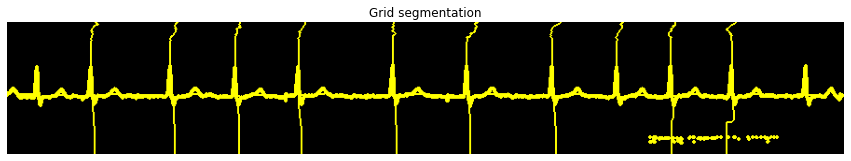

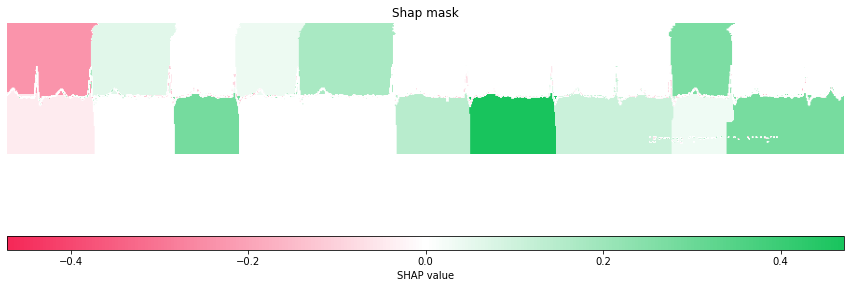

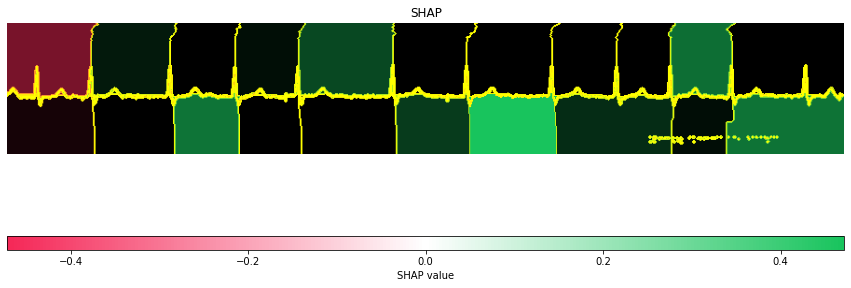

In [4]:
if __name__ == '__main__':
    # Carregando modelo de classificação
    model = tf.keras.models.load_model('modelD2long.h5', compile=False)
    #model.summary()

    # Abrindo dataset de exemplo
    h5 = h5py.File('ecgD2longImgs.h5', 'r') # Open file
    data = h5['2d'] # D2 images
    
    # LOAD IMAGE
    # Artigo: normal (3) | fa (35)
    idx = 35

    x_img = data[idx] # FA
    x_img = np.expand_dims(x_img, axis = 0) # input shape nedded for the model

    print('## Image to be analyzed: ', idx)
    print('## Image prediction (NORMAL = 0 | FA = 1): ', int(model.predict(x_img)))
    
    grid_size = [3,10]
    nsamples = 250
    seg_method = 'quickshift'
    
    # Aplica interpretador
    ShapInterpreter(model, x_img, nsamples, seg_method, grid_size)
    
    #obs. se nsamples for menor que num_superpixels é possível que dê erro